In [1]:
import pandas as pd

# Veri yükleme
df = pd.read_csv("birlesik_veri.csv", parse_dates=["datetime"], index_col="datetime")
df.shape, df.columns


((26304, 30),
 Index(['PTF (TL/MWh)', 'PTF (USD/MWh)', 'PTF (EUR/MWh)',
        'Tüketim Miktarı(MWh)', 'Toplam', 'Doğal Gaz', 'Barajlı', 'Linyit',
        'Akarsu', 'İthal Kömür', 'Rüzgar', 'Güneş', 'Fuel Oil', 'Jeotermal',
        'Asfaltit Kömür', 'Taş Kömür', 'Biyokütle', 'Nafta', 'LNG',
        'Uluslararası', 'Atık Isı', 'GRF (TL/1000Sm3)', 'GRF (USD/1000Sm3)',
        'GRF (EUR/1000Sm3)', 'GRF (USD/MMBtu)', 'API2 (USD/ton)',
        'ALLSKY_SFC_SW_DWN', 'WS50M', 'T2M', 'T2MDEW'],
       dtype='object'))

In [2]:
# HEDEF VE GIRDI SECIMI

target_col = "PTF (TL/MWh)"

# Tahmin için kullanılacak öznitelikler (PTF hariç hepsi)
X = df.drop(columns=[target_col])
y = df[target_col]


In [3]:
# EKSIK VERILERI TAMAMLAMA

X = X.ffill().bfill()
y = y[X.index]  # Hedef sütunla senkronize kal


In [4]:
# OLCEKLEME, EGITIM VE TEST AYRIMI

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Ölçekleyiciler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ölçekleme
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Zaman sıralı bölme (%80 eğitim, %20 test)
split_point = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_point], X_scaled[split_point:]
y_train, y_test = y_scaled[:split_point], y_scaled[split_point:]


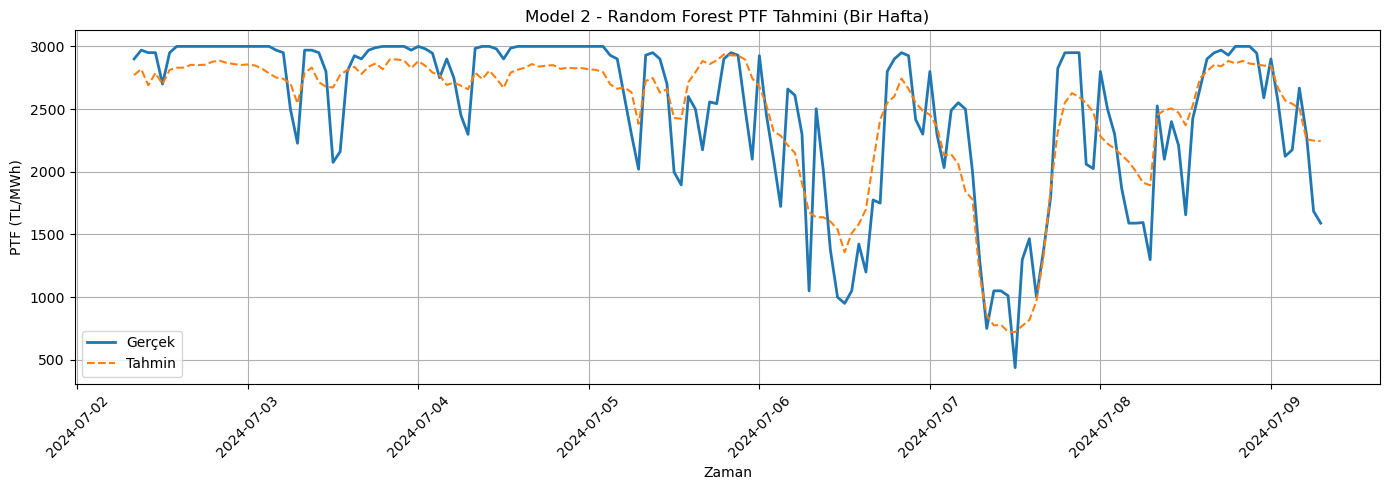

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

# Veriyi oku
df = pd.read_csv("birlesik_veri.csv", parse_dates=["datetime"], index_col="datetime")

# Giriş ve çıkış değişkenlerini ayır
target_col = "PTF (TL/MWh)"
feature_cols = df.columns.drop(["PTF (TL/MWh)", "PTF (USD/MWh)", "PTF (EUR/MWh)"])
X = df[feature_cols]
y = df[target_col]

# Eksik verileri doldur
X = X.ffill().bfill()
y = y.ffill().bfill()

# Veriyi ölçeklendir
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Zaman serisi bölme (train-test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

# Random Forest modelini eğit
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Tahmin yap
y_pred_scaled = rf.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metrikleri hesapla
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Grafik
plt.figure(figsize=(14, 5))
plt.plot(df.index[test_idx][:168], y_true[:168], label="Gerçek", linewidth=2)
plt.plot(df.index[test_idx][:168], y_pred[:168], label="Tahmin", linestyle="--")
plt.title("Model 2 - Random Forest PTF Tahmini (Bir Hafta)")
plt.ylabel("PTF (TL/MWh)")
plt.xlabel("Zaman")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [6]:
(mae, mape)

(261.1235595574817, 12.356774758047672)